# Favor Polar Multi & Convergence Plots

Analysis notebook for producing publication figures.
- Produces multi plot of polarizability term vs dipole moment term for three runs
- Produces convergence plot of best polarizability and dipole terms vs generation for three runs

## User Input

In [13]:
# Paths to analysis files

# amino/nitro endgroups run
n_path = 'n/full_analysis_data_fixed.csv'
# methoxy/cyano endgroups run
co_path = 'co/full_analysis_data_fixed.csv'
# dimethyl amino/trifluromethyl run
cf3_path = 'cf3/full_analysis_data_fixed.csv'

## Imports and Method Definitions

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.constants as sc

In [15]:
# takes dataframe with cols: gen, filename, alpha, mu, vol
# returns dataframe with cols: gen, filename, alpha_t_<data_set>, mu_t_<data_set>

def convert_to_clausius_terms(df, data_set=''):
    df2 = pd.DataFrame()
    
    if data_set != '':
            data_set = '_' + data_set

    # loop over rows
    for x in range(df.shape[0]):

        # alpha in bohr^3, mu in debye, vol in A^3
        gen = df.iloc[x,1]
        filename = df.iloc[x,2]
        alpha = df.iloc[x,3]
        mu = df.iloc[x,4]
        vol = df.iloc[x,5]

        # convert polarizability (volume) to SI units (bohr^3 to m^3)    
        si_alpha_prime = alpha * (5.29177E-11)**3

        # convert dipole moment to SI units (debye to C*m)
        # 1 debye = 3.3E-30 C*m
        si_mu = mu * 3.3356E-30

        # convert volume to SI units (A^3 to m^3)
        si_vol = vol * 1E-30

        # define molecular density N/V (assume packing of 68%)
        n_v = 0.68/si_vol    

        # calculate Clausius-Mossotti equation term values (assume temperature of 300K)
        a_term = n_v * (si_alpha_prime * 4 * sc.pi * sc.epsilon_0)/(3 * sc.epsilon_0)
        m_term = n_v * (si_mu**2)/(9 * sc.epsilon_0 * sc.Boltzmann * 300)

        claus_sum = a_term + m_term

        # solve C-M eqn for dielectric constant
#         dielec = (2 * claus_sum + 1)/(1 - claus_sum)
        
        temp_df = pd.DataFrame({'gen':[gen], 'filename':[filename], ('alpha_t%s' % data_set):[a_term], ('mu_t%s' % data_set):[m_term]})
        df2 = df2.append(temp_df, ignore_index=True)

    return df2

## Data Processing

df: Make DFs from each GA full analysis file  
NOTE: Within generations, polymers are listed from best ranked to worst ranked

In [16]:
df_n = pd.read_csv(n_path)
df_co = pd.read_csv(co_path)
df_cf3 = pd.read_csv(cf3_path)

df_cf3.tail()

,run,gen,filename,alpha,mu,vol
12795,1,400,714_463_000010,815.157678,18.759,913.048670
12796,1,400,714_927_000100,828.938861,20.287,930.096072
12797,1,400,749_98_101000,818.142230,8.432,935.048057
12798,1,400,676_98_100010,824.790574,15.312,1026.066357
12799,1,400,1153_98_110000,1677.411114,18.530,2202.712130


df_multi: Make combined DF of calculated alpha and mu terms from all datasets

In [17]:
df_multi = convert_to_clausius_terms(df_n, 'n')

temp_df = convert_to_clausius_terms(df_co, 'co')
df_multi = pd.concat([df_multi[['gen', 'alpha_t_n', 'mu_t_n']], temp_df[['alpha_t_co', 'mu_t_co']]], axis=1)

temp_df = convert_to_clausius_terms(df_cf3, 'cf3')
df_multi = pd.concat([df_multi, temp_df[['alpha_t_cf3', 'mu_t_cf3']]], axis=1)

df_multi.tail()

,gen,alpha_t_n,mu_t_n,alpha_t_co,mu_t_co,alpha_t_cf3,mu_t_cf3
12795,400,0.390442,6.068416,0.354390,8.441644,0.376832,8.834595
12796,400,0.368250,0.533350,0.353166,4.761102,0.376179,10.143062
12797,400,0.365529,2.492616,0.352120,1.231336,0.369314,1.742964
12798,400,0.356329,17.874998,0.346123,25.212483,0.339288,5.237808
12799,400,0.318437,4.578627,0.305409,0.531151,0.321427,3.573175


In [18]:
df_multi.head()

,gen,alpha_t_n,mu_t_n,alpha_t_co,mu_t_co,alpha_t_cf3,mu_t_cf3
0,1,0.372649,36.973633,0.373413,2.214432,0.361878,2.538989
1,1,0.359660,0.191452,0.364165,18.576047,0.358759,7.904140
2,1,0.358603,22.507598,0.362780,0.942695,0.356303,1.968174
3,1,0.355752,0.752870,0.360093,2.794722,0.355568,4.227931
4,1,0.355023,8.793777,0.359908,1.667986,0.352633,1.052658


df_max: Make combined DF of max calculated alpha and mu terms from each generation for all datasets  
ASSUMES 32 polymers per generation, and within generation polymer rows are listed from best ranked to worst ranked

In [19]:
# max values found based on ordering of df_multi rows inherited from original df's: 
# within each generation, best ranked (max) polymer is top row

df_max = pd.DataFrame()

num_gen = df_multi.iloc[df_multi.shape[0]-1,0]
for x in range(num_gen):
    
    gen = df_multi.iloc[0+x*32, 0]
    max_at_n = df_multi.iloc[0+x*32, 1]
    max_mt_n = df_multi.iloc[0+x*32, 2]
    max_at_co = df_multi.iloc[0+x*32, 3]
    max_mt_co = df_multi.iloc[0+x*32, 4]
    max_at_cf3 = df_multi.iloc[0+x*32, 5]
    max_mt_cf3 = df_multi.iloc[0+x*32, 6]
    
    temp_df = pd.DataFrame({'gen':[gen], 'max_at_n':[max_at_n], 'max_mt_n':[max_mt_n], 'max_at_co':[max_at_co], 'max_mt_co':[max_mt_co], 'max_at_cf3':[max_at_cf3], 'max_mt_cf3':[max_mt_cf3]})
    df_max = df_max.append(temp_df, ignore_index=True)

df_max.tail()

,gen,max_at_n,max_mt_n,max_at_co,max_mt_co,max_at_cf3,max_mt_cf3
395,396,0.399949,6.434421,0.397288,1.583277,0.391626,5.018946
396,397,0.399949,6.434421,0.397288,1.583277,0.391626,5.018946
397,398,0.399949,6.434421,0.397288,1.583277,0.391626,5.018946
398,399,0.399949,6.434421,0.397288,1.583277,0.391626,5.018946
399,400,0.399949,6.434421,0.397288,1.583277,0.391626,5.018946


## Generate Plots

Set global font sizes for plotting

In [20]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

Find max and min values for each run (to confirm plot limits)

In [21]:
# polarizability term
min_polar = min(min(df_multi['alpha_t_n']), min(df_multi['alpha_t_co']), min(df_multi['alpha_t_cf3']))
max_polar = max(max(df_multi['alpha_t_n']), max(df_multi['alpha_t_co']), max(df_multi['alpha_t_cf3']))

# dipole moment term
min_dip = min(min(df_multi['mu_t_n']), min(df_multi['mu_t_co']), min(df_multi['mu_t_cf3']))
max_dip = max(max(df_multi['mu_t_n']), max(df_multi['mu_t_co']), max(df_multi['mu_t_cf3']))

print('min_polar_term', min_polar)
print('max_polar_term', max_polar)
print('min_dipole_term', min_dip)
print('max_dipole_term', max_dip)

min_polar_term 0.2885698730100872
max_polar_term 0.3999487090152828
min_dipole_term 0.006151086955738846
max_dipole_term 100.27770612856588


### Multiplot

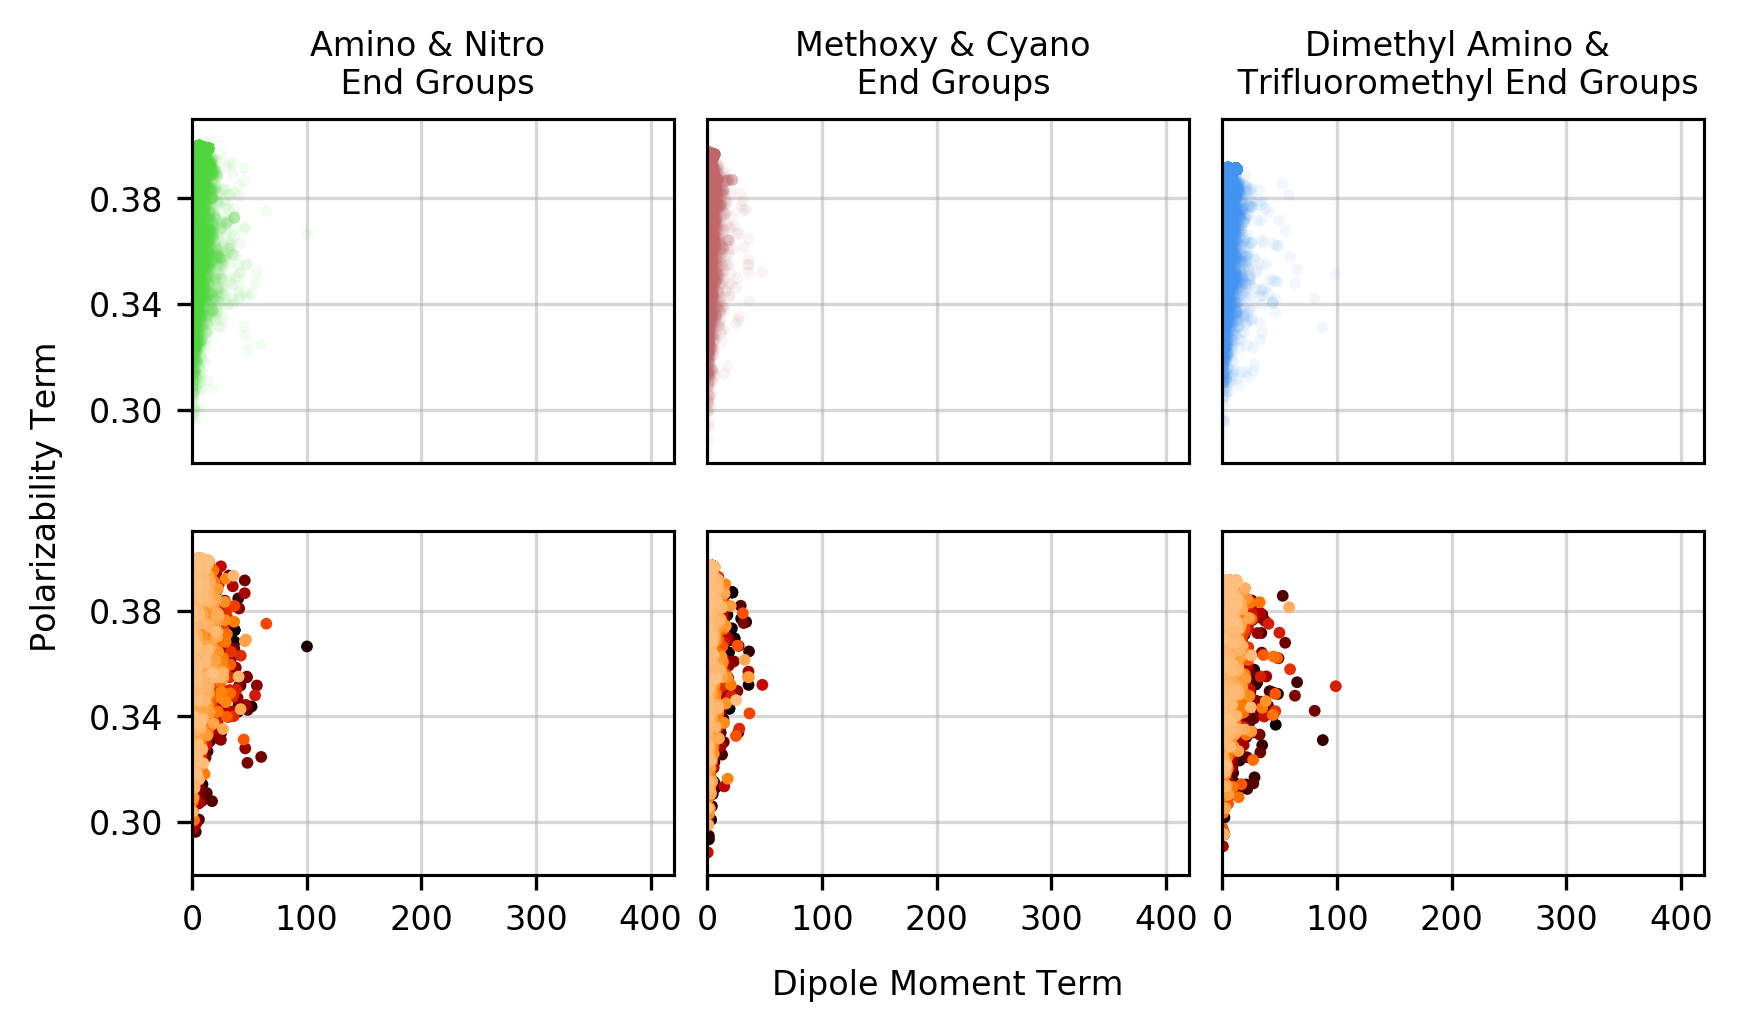

In [22]:
plt.rcParams['axes.linewidth'] = 0.75 #set the value globally
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey=True, dpi=300)

# set figure axes
xlimits = (0, 420)
xticks = [0, 100, 200, 300, 400]

ylimits = (0.28, 0.41)
yticks = [0.30, 0.34, 0.38]

#scatter plots
# n
ax1.scatter(x=df_multi['mu_t_n'], y=df_multi['alpha_t_n'], s=8, c='#50d63d', edgecolor='none', alpha = 0.07)
ax1.set_title('Amino & Nitro \n End Groups')
ax1.set(ylim=ylimits, xlim=xlimits)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels('')

ax1.set_xticks(xticks)
ax1.grid(alpha=0.5)
ax1.set_axisbelow(True)

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False


# co
ax2.scatter(x=df_multi['mu_t_co'], y=df_multi['alpha_t_co'], s=8, c='#c1666b', edgecolor='none', alpha = 0.07)
ax2.set_title('Methoxy & Cyano \n End Groups')
ax2.set(ylim=ylimits, xlim=xlimits)
ax2.set_xlabel('')
ax2.set_xticklabels('')

ax2.set_xticks(xticks)
ax2.grid(alpha=0.5)
ax2.set_axisbelow(True)

for tic in ax2.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax2.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

# cf3
ax3.scatter(x=df_multi['mu_t_cf3'], y=df_multi['alpha_t_cf3'], s=8, c='#4394f0', edgecolor='none', alpha = 0.07)
ax3.set_title('Dimethyl Amino & \n Trifluoromethyl End Groups')
ax3.set(ylim=ylimits, xlim=xlimits)
ax3.set_xlabel('')
ax3.set_xticklabels('')

ax3.set_xticks(xticks)
ax3.grid(alpha=0.5)
ax3.set_axisbelow(True)

for tic in ax3.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax3.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

# heatmap age plots
colors = cm.gist_heat
# n
ax4.scatter(x=df_multi['mu_t_n'], y=df_multi['alpha_t_n'], s=8,  edgecolor='none', c=(np.ceil(df_multi['gen']/1.8).astype(int)).apply(colors))
ax4.set(ylim=ylimits, xlim=xlimits)
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_xticks(xticks)
ax4.set_yticks(yticks)

ax4.set_xticks(xticks)
ax4.grid(alpha=0.5)
ax4.set_axisbelow(True)


# co
ax5.scatter(x=df_multi['mu_t_co'], y=df_multi['alpha_t_co'], s=8,  edgecolor='none', c=(np.ceil(df_multi['gen']/1.8).astype(int)).apply(colors))
ax5.set(ylim=ylimits, xlim=xlimits)
ax5.set_xlabel('')
ax5.set_xticks(xticks)

ax5.set_xticks(xticks)
ax5.grid(alpha=0.5)
ax5.set_axisbelow(True)

for tic in ax5.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

# cf3
ax6.scatter(x=df_multi['mu_t_cf3'], y=df_multi['alpha_t_cf3'], s=8,  edgecolor='none', c=(np.ceil(df_multi['gen']/1.8).astype(int)).apply(colors))
ax6.set(ylim=ylimits, xlim=xlimits)
ax6.set_xlabel('')
ax6.set_xticks(xticks)

ax6.set_xticks(xticks)
ax6.grid(alpha=0.5)
ax6.set_axisbelow(True)

for tic in ax6.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

top = 0.75
bottom = 0.12
midpoint = (top+bottom)/2

left = 0.11
right = 0.95

# label axes
fig.text((left+right)/2, 0.02,'Dipole Moment Term', ha='center')
fig.text(0.02, (top+bottom)/2,'Polarizability Term', va='center', rotation='vertical')

plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, wspace=0.07)

# plt.savefig('favor_polar_multi_plot.pdf', transparent=False, bbox_inches='tight')
# plt.savefig('favor_polar_multi_plot.png', transparent=False, bbox_inches='tight')

plt.show()


Find max and min values from list of generation maximums for each run (to confirm plot limits)

In [23]:
# polarizability term
min_polar_m = min(min(df_max['max_at_n']), min(df_max['max_at_co']), min(df_max['max_at_cf3']))
max_polar_m = max(max(df_max['max_at_n']), max(df_max['max_at_co']), max(df_max['max_at_cf3']))

# dipole moment term
min_dip_m = min(min(df_max['max_mt_n']), min(df_max['max_mt_co']), min(df_max['max_mt_cf3']))
max_dip_m = max(max(df_max['max_mt_n']), max(df_max['max_mt_co']), max(df_max['max_mt_cf3']))

print('min_polar_term', min_polar_m)
print('max_polar_term', max_polar_m)
print('min_dipole_term', min_dip_m)
print('max_dipole_term', max_dip_m)

min_polar_term 0.36187847630932646
max_polar_term 0.3999487090152828
min_dipole_term 0.12964602212870072
max_dipole_term 36.97363280035087


### Convergence Plot

/ihome/crc/install/python/miniconda3-3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/ihome/crc/install/python/miniconda3-3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/ihome/crc/install/python/miniconda3-3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


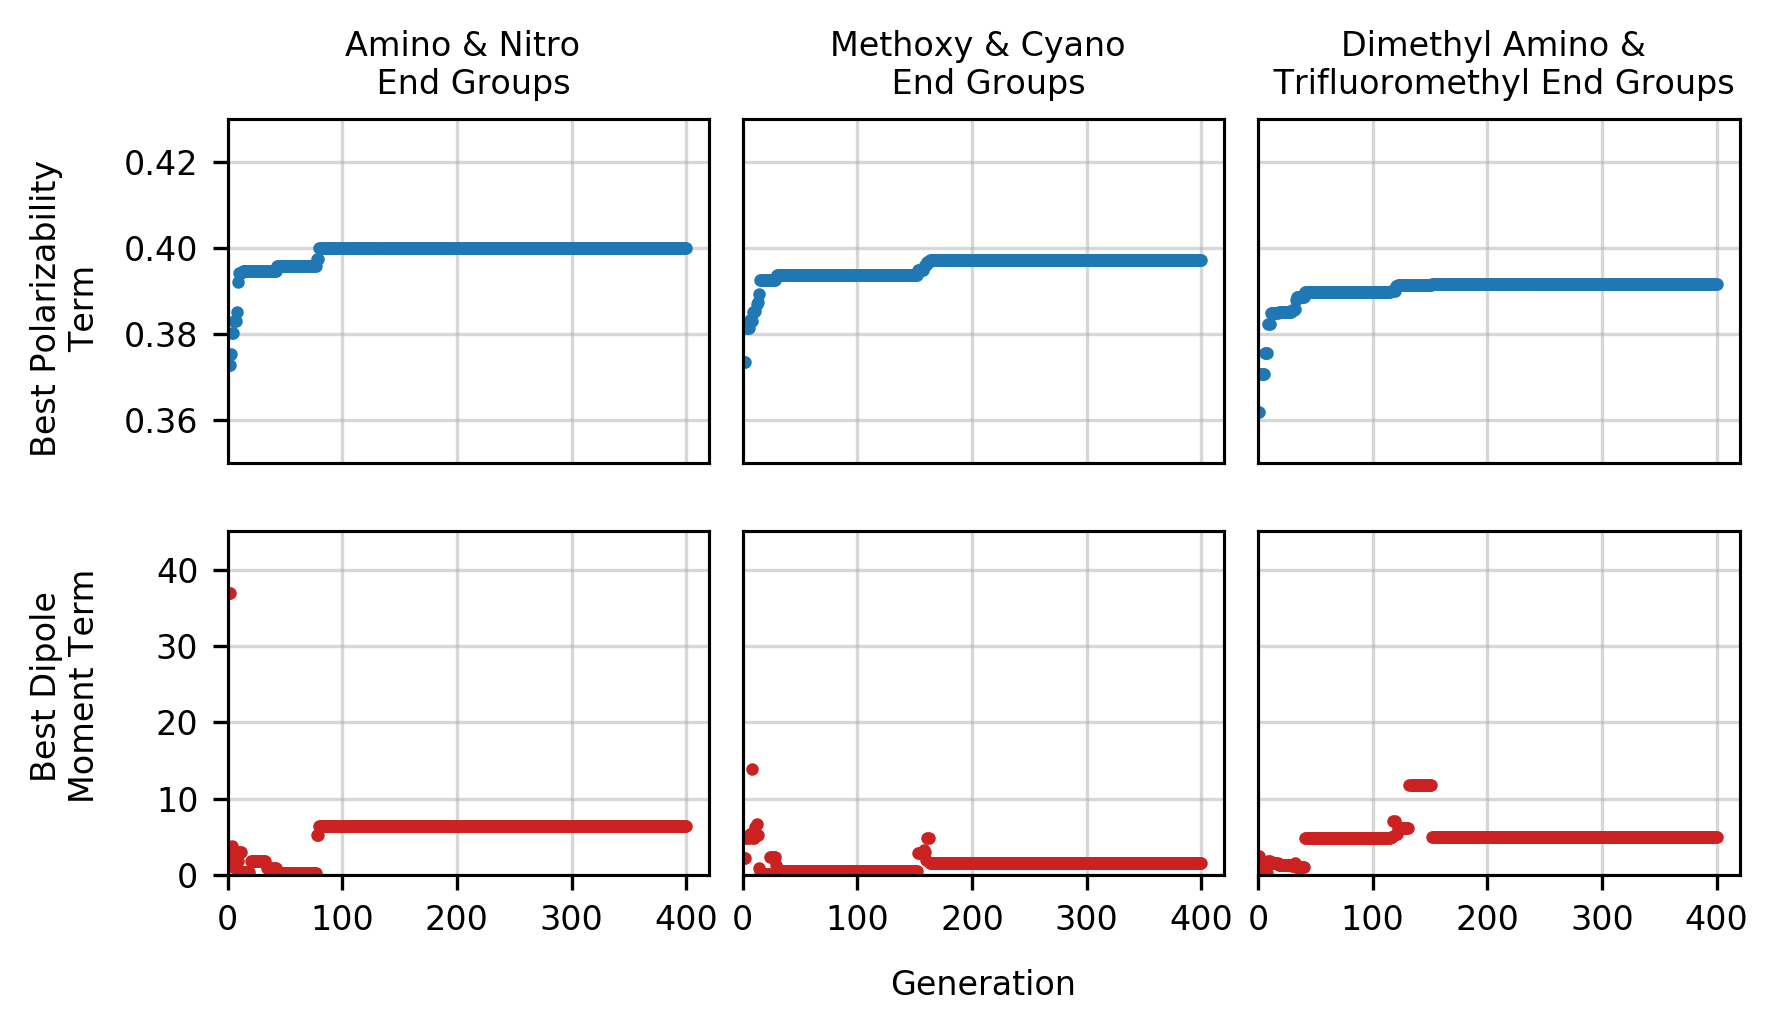

In [24]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, sharex=True, dpi=300)

# set figure axes
xlimits = (0, 420)
# xticks = []

# polarizability y axis
ylim_a = (0.35, 0.43)
yticks_a = [0.36, 0.38, 0.4, 0.42]

# dipole moment y axis
ylim_m = (0, 45)
# yticks_m =[]

# # set figure axes
# xlimits = (0, 420)
# # xticks = []

# # polarizability y axis
# ylim_a = (0.31, 0.39)
# yticks_a = [0.32, 0.34, 0.36, 0.38]

# # dipole moment y axis
# ylim_m = (0, 450)
# # yticks_m =[]

ax1.plot('gen', 'max_at_n', data=df_max, linestyle='', marker='o', markersize=2)
ax1.set_title('Amino & Nitro \n End Groups')
# ax1.set_ylabel('Best Polarizability Term')
ax1.set(ylim=ylim_a, xlim=xlimits)
ax1.set_yticks(yticks_a)

ax1.set_xticks(xticks)
ax1.grid(alpha=0.5)
ax1.set_axisbelow(True)

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

ax2.plot('gen', 'max_mt_n', data=df_max, linestyle='', marker='o', markersize=2,color='#cb2121')
# ax2.set_ylabel('Best Dipole Term')
ax2.set(ylim=ylim_m, xlim=xlimits)

ax2.set_xticks(xticks)
ax2.grid(alpha=0.5)
ax2.set_axisbelow(True)

ax3.plot('gen', 'max_at_co', data=df_max, linestyle='', marker='o', markersize=2)
ax3.set_title('Methoxy & Cyano \n End Groups')
ax3.set_yticklabels('')
ax3.set(ylim=ylim_a, xlim=xlimits)

ax3.set_xticks(xticks)
ax3.grid(alpha=0.5)
ax3.set_axisbelow(True)

for tic in ax3.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax3.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

ax4.plot('gen', 'max_mt_co', data=df_max, linestyle='', marker='o', markersize=2,color='#cb2121')
ax4.set_yticklabels('')
ax4.set(ylim=ylim_m, xlim=xlimits)

ax4.set_xticks(xticks)
ax4.grid(alpha=0.5)
ax4.set_axisbelow(True)

for tic in ax4.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

ax5.plot('gen', 'max_at_cf3', data=df_max, linestyle='', marker='o', markersize=2)
ax5.set_title('Dimethyl Amino & \n Trifluoromethyl End Groups')
ax5.set_yticklabels('')
ax5.set(ylim=ylim_a, xlim=xlimits)

ax5.set_xticks(xticks)
ax5.grid(alpha=0.5)
ax5.set_axisbelow(True)

for tic in ax5.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax5.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

ax6.plot('gen', 'max_mt_cf3', data=df_max, linestyle='', marker='o', markersize=2,color='#cb2121')
ax6.set_yticklabels('')
ax6.set(ylim=ylim_m, xlim=xlimits)

ax6.set_xticks(xticks)
ax6.grid(alpha=0.5)
ax6.set_axisbelow(True)

for tic in ax6.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    
top = 0.75
bottom = 0.12
midpoint = (top+bottom)/2

left = 0.11
right = 0.95
    
fig.text((left+right)/2, 0.02,'Generation', ha='center')
fig.text(0.02, (midpoint+top)/2,'Best Polarizability\nTerm', ha = 'center', va='center', rotation='vertical')
fig.text(0.02, (bottom+midpoint)/2,'Best Dipole\nMoment Term', ha = 'center', va='center', rotation='vertical')


plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, wspace=0.07)

# plt.savefig('favor_polar_convergence_plots.pdf', transparent=False, bbox_inches='tight')
# plt.savefig('favor_polar_convergence_plots.png', transparent=False, bbox_inches='tight')

plt.show()